In [42]:
import torch
import pandas as pd
import os
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import natsort
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms


In [43]:
TRAIN_DATA_PATH = "/home/filipe/Downloads/research/cifar-10/train/"
BATCH_SIZE = 256


In [44]:
class Cifar10Dataloader(torch.utils.data.Dataset):

    def __init__(self, main_dir: str, class_file: str, label_column: str, sub_images: tuple):

        all_imgs = os.listdir(main_dir)
        self.main_dir = main_dir
        self.X = natsort.natsorted(all_imgs)
        self.y = pd.read_csv(class_file)[label_column].values
        self.sub_images = sub_images

        self.base_transformers = transforms.Compose([
            transforms.PILToTensor()
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img_loc = os.path.join(self.main_dir, self.X[index])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.base_transformers(image)

        size_x = tensor_image.size(dim=1) // self.sub_images[0]
        size_y = tensor_image.size(dim=2) // self.sub_images[1]
        start_x = 0
        sub_tensors = [torch.rand(size_x * size_y * 3)]

        for cut_x in range(self.sub_images[0]):
            start_y = 0
            for cut_y in range(self.sub_images[1]):
                sub_tensors.append(
                    tensor_image[:, start_x:size_x*cut_x+size_x, start_y:size_y*cut_y+size_y].flatten() / 255)

                start_y += size_y
            start_x += size_x

        return torch.cat(sub_tensors).reshape(1+self.sub_images[0]*self.sub_images[1], size_x*size_y*3)


In [45]:
def plot_images(tensors, shape, figsize, img_shape_restore):
    # fig, axs = plt.subplots(*shape)

    fig = plt.figure(figsize=figsize)  # Notice the equal aspect ratio
    ax = [fig.add_subplot(*shape, i+1) for i in range(shape[0] * shape[1])]
    
    tensors = tensors[0]

    for i in range(shape[0]):
        for j in range(shape[1]):
            idx = i * shape[1] + j
            img = tensors[idx].reshape(img_shape_restore)

            ax[idx].get_xaxis().set_visible(False)
            ax[idx].get_yaxis().set_visible(False)            
            ax[idx].imshow(img.permute(1, 2, 0))

    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


In [46]:
cifar_data = Cifar10Dataloader("/home/filipe/Downloads/research/cifar-10/train/",
                               "/home/filipe/Downloads/research/cifar-10/trainLabels.csv", "label", (3, 3))


In [47]:
test_data_loader = data.DataLoader(
    cifar_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)


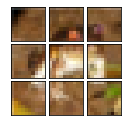

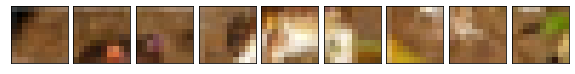

In [48]:
for _data in test_data_loader:
    plot_images(_data[: , 1:], (3, 3), figsize=(2,2), img_shape_restore=(3,10,10))
    plot_images(_data[: , 1:], (1, 9), figsize=(10,10), img_shape_restore=(3,10,10))
    break


In [49]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads ==
                embed_size), f"Embed size needs to be divisible by heads ({heads})"

        self.tovalues = nn.Linear(embed_size, embed_size, bias=False)
        self.tokeys = nn.Linear(embed_size, embed_size, bias=False)
        self.toqueries = nn.Linear(embed_size, embed_size, bias=False)

        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)

    def forward(self, x):
        
        N, batch, embedding = x.size()
        assert embedding == self.embed_size, f'Input embedding dim ({embedding}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x)
        queries = self.toqueries(x)
        values  = self.tovalues(x)

        keys    = keys.view(N, batch, self.heads, self.head_dim)
        queries = queries.view(N, batch, self.heads, self.head_dim)
        values  = values.view(N, batch, self.heads, self.head_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape(N:n, query_len: q, heads: h, heads_dim: d) => nqhd
        # keys shape(N:n, key_len: k, heads: h, heads_dim: d) => nkhd
        # energy shape(N:n, heads: h, query_len: q, key_len:k) => nhqk

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)

        out = torch.einsum("nhqk,nkhd->nqhd", [attention, values])
        # attetion shape(N:n, heads: h, query_len: q, key_len: k) => nhqk
        # values shape(N:n, values_len: v, heads: h, heads_dim: d) => nvhd (v = k) nkhd
        # out shape(N:n, query_len: q, heads: h, heads_dim: d) => nqhd

        out = out.reshape(N, batch, self.heads*self.head_dim)

        out = self.fc_out(out)
        return out

In [50]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, ff_hidden_mult=4, dropout=0.2):
        super(TransformerBlock, self).__init__()
        
        self.attention = SelfAttention(embed_size, heads)

        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.ff = nn.Sequential(
            nn.Linear(embed_size, ff_hidden_mult * embed_size),
            nn.GELU(),
            nn.Linear(ff_hidden_mult * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):

        _x = self.norm1(x)

        attention = self.dropout(self.attention(_x))

        x = attention + x

        _x = self.norm2(x)
        _x = self.dropout(self.ff(_x))

        return _x + x


In [123]:
class VisionTransformer(nn.Module):

    def __init__(self, n_images, embed_size, n_classes, heads=5, n_transformers=5):
        super(VisionTransformer, self).__init__()

        self.n_transformers = n_transformers
        self.n_classes = n_classes

        self.image_embbeding = nn.Linear(embed_size, embed_size)
        self.position_embbeding = nn.Linear(n_images, embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads)

        self.linear_to_classes = nn.Linear(embed_size*n_images, n_classes)

    def forward(self, x):
        batch, n, embed_size = x.size()

        positions = torch.tensor(range(0, n)).float().cuda()

        position_embed = self.position_embbeding(positions)
        img_embed = self.image_embbeding(x)

        x = position_embed + img_embed

        for i in range(self.n_transformers):
            x = self.transformer_block(x, None)

        x = x.view(batch, n*embed_size)

        x = self.linear_to_classes(x)
        x = torch.softmax(x, dim=1)

        return x


In [124]:
net = VisionTransformer(10, 300, 10)
net.cuda()

VisionTransformer(
  (image_embbeding): Linear(in_features=300, out_features=300, bias=True)
  (position_embbeding): Linear(in_features=10, out_features=300, bias=True)
  (transformer_block): TransformerBlock(
    (attention): SelfAttention(
      (tovalues): Linear(in_features=300, out_features=300, bias=False)
      (tokeys): Linear(in_features=300, out_features=300, bias=False)
      (toqueries): Linear(in_features=300, out_features=300, bias=False)
      (fc_out): Linear(in_features=300, out_features=300, bias=True)
    )
    (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (ff): Sequential(
      (0): Linear(in_features=300, out_features=1200, bias=True)
      (1): GELU(approximate=none)
      (2): Linear(in_features=1200, out_features=300, bias=True)
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (linear_to_classes): Linear(in_features=3000, out_features=10, bias=True)
)

In [125]:
for _data in test_data_loader:
    _data = _data.float()
    _data = _data.cuda()
    
    res = net.forward(_data)

In [132]:
res[0].round(decimals=2)

tensor([0.0400, 0.0000, 0.4900, 0.0400, 0.0500, 0.0600, 0.0000, 0.0000, 0.3100,
        0.0000], device='cuda:0', grad_fn=<RoundBackward1>)